# Traffic Signs Classfier

## Step 0: Load Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = "traffic-signs-data-synth/train.p"
validation_file= "traffic-signs-data/valid.p"
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

print()
print("Image Shape: {}".format(X_train[0].shape))
print()
print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_valid)))
print("Test Set:       {} samples".format(len(X_test)))


Image Shape: (32, 32, 3)

Training Set:   63478 samples
Validation Set: 4410 samples
Test Set:       12630 samples


## Step 1: Dataset Summary & Exploration

### Data Summary

In [2]:
# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = max(y_train)+1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 63478
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Visualize Data

5


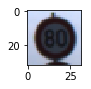

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index]

plt.figure(figsize=(1,1))
plt.imshow(image)
print(y_train[index])

### Classes Analysis

<Container object of 43 artists>

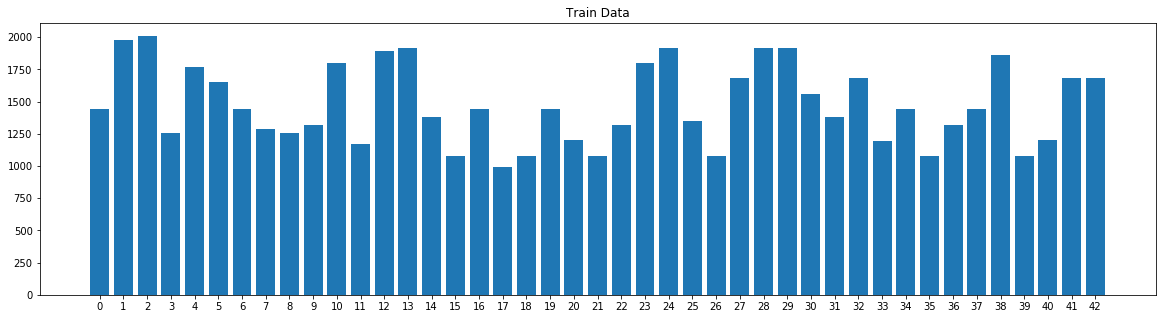

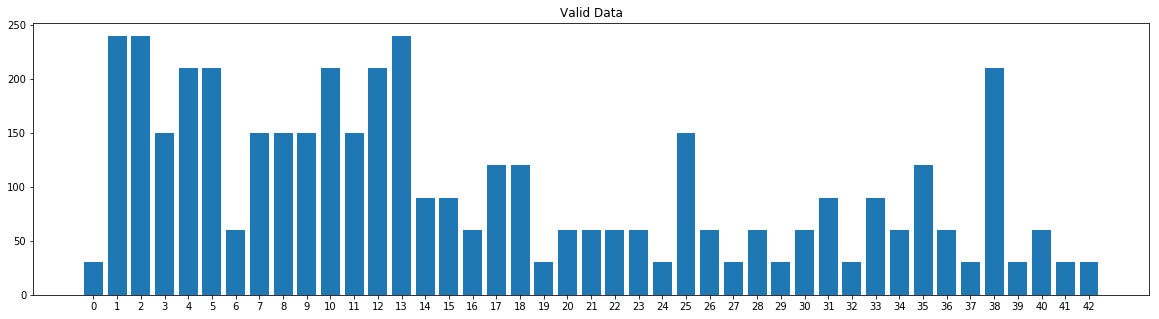

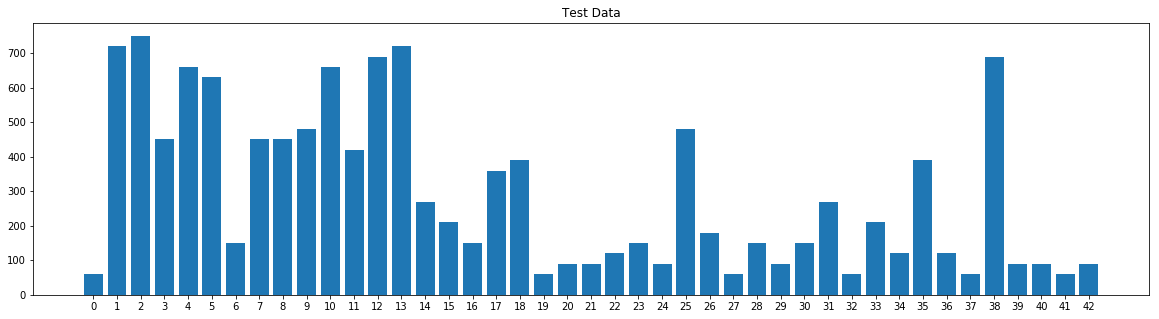

In [4]:
x = range(n_classes)
train_len= [0] * n_classes
vaild_len = [0] * n_classes
test_len = [0] * n_classes

for i in range(len(y_train)):
    train_len[y_train[i]] += 1

for i in range(len(y_valid)):
    vaild_len[y_valid[i]] += 1

for i in range(len(y_test)):
    test_len[y_test[i]] += 1

fig = plt.figure(0,figsize=(20,5))
ax = fig.add_subplot(111)
ax.set_title('Train Data')
plt.xticks(x)
plt.bar(x,train_len)

fig2 = plt.figure(1,figsize=(20,5))
ax2 = fig2.add_subplot(111)
ax2.set_title('Valid Data')
plt.xticks(x)
plt.bar(x,vaild_len)

fig3 = plt.figure(2,figsize=(20,5))
ax3 = fig3.add_subplot(111)
ax3.set_title('Test Data')
plt.xticks(x)
plt.bar(x,test_len)

## Step 2: Model Design, Training and Testing

### PreProcess Data

In [5]:
from sklearn.utils import shuffle
import cv2

def normalize_grayscale(image_data):
    a = 0.1
    b = 0.9
    min_dat = 0
    max_dat = 255
    return (a + ((image_data - min_dat)*(b-a)/(max_dat-min_dat)))

def deNormalize_grayscale(image_data):
    a = 0.1
    b = 0.9
    min_dat = 0
    max_dat = 255
    
    return ((image_data - a) * (max_dat-min_dat) / (b-a)) + min_dat
    
X_train_gray = []
X_valid_gray = []
X_test_gray = []

X_train_gray_normalized = []
X_valid_gray_normalized = []
X_test_gray_normalized = []

for i in range(len(X_train)):
    img = X_train[i]
    img = cv2.cvtColor( img, cv2.COLOR_RGB2GRAY)
    X_train_gray_normalized.append(normalize_grayscale(img).reshape(32,32,1))
    X_train_gray.append(img.reshape(32,32,1));
    

for i in range(len(X_valid)):
    img = X_valid[i]
    img = cv2.cvtColor( img, cv2.COLOR_RGB2GRAY)
    X_valid_gray_normalized.append(normalize_grayscale(img).reshape(32,32,1))
    X_valid_gray.append(img.reshape(32,32,1));
    
for i in range(len(X_test)):
    img = X_test[i]
    img = cv2.cvtColor( img, cv2.COLOR_RGB2GRAY)
    X_test_gray_normalized.append(normalize_grayscale(img).reshape(32,32,1))
    X_test_gray.append(img.reshape(32,32,1));
    
X_train_gray_normalized, y_train = shuffle(X_train_gray_normalized, y_train)

### Model Architecture

In [6]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID') + b
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return  tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='VALID')

def LeNet(x,keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Store layers weight & bias
    #initializer = tf.contrib.layers.xavier_initializer_conv2d()
    global weights
    global biases
        
    weights = {
        'wc1': tf.Variable(tf.truncated_normal(shape =(5, 5, 1, 6), mean = mu, stddev = sigma)),#tf.Variable(initializer(shape =(5, 5, 3, 6))),
        'wc2': tf.Variable(tf.truncated_normal(shape = (5, 5, 6, 16), mean = mu, stddev = sigma)),#tf.Variable(initializer(shape = (5, 5, 6, 16))),
        'wd1': tf.Variable(tf.truncated_normal(shape =(5*5*16 + 14*14*6, 120), mean = mu, stddev = sigma)),#tf.Variable(initializer(shape =(5*5*16, 120))),
        'wd2': tf.Variable(tf.truncated_normal(shape = (120, 84), mean = mu, stddev = sigma)),#tf.Variable(initializer(shape = (120, 84))),
        'out': tf.Variable(tf.truncated_normal(shape = (84, n_classes), mean = mu, stddev = sigma))#tf.Variable(initializer(shape = (84, n_classes)))
            }

    
    biases = {
        'bc1': tf.Variable(tf.zeros(6)),
        'bc2': tf.Variable(tf.zeros(16)),
        'bd1': tf.Variable(tf.zeros(120)),
        'bd2': tf.Variable(tf.zeros(84)),
        'out': tf.Variable(tf.zeros(n_classes))
            }
    
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    global conv1
    global pool_conv1
    
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    pool_conv1 = maxpool2d(conv1, k=2)
    
    # Layer 2: Convolutional. Output = 10x10x16.
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    global conv2
    global pool_conv2

    conv2 = conv2d(pool_conv1, weights['wc2'], biases['bc2'])
    pool_conv2 = maxpool2d(conv2, k=2)
    
    # Flatten. Input = 5x5x16 + 14x14x6. Output = 1576.
    pool_conv1_flat = flatten(pool_conv1)
    pool_conv2_flat = flatten(pool_conv2)
    
    fc0 = tf.concat_v2([pool_conv1_flat, pool_conv2_flat],1)
    
    # Layer 3: Fully Connected. Input = 1576. Output = 120.
    fc1 = tf.matmul(fc0, weights['wd1']) + biases['bd1']
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2 = tf.matmul(fc1, weights['wd2']) + biases['bd2']
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep_prob)
    
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    out = tf.matmul(fc2, weights['out']) + biases['out']    
    
    return out

### Features and Labels

In [7]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, n_classes)

### Training Pipeline

In [40]:
rate = 0.001
EPOCHS = 15
BATCH_SIZE = 80

logits = LeNet(x,keep_prob)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

### Model Evaluation

In [41]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Model Training

Training...

EPOCH 1 ...
Training Accuracy = 0.788
Validation Accuracy = 0.742

EPOCH 2 ...
Training Accuracy = 0.896
Validation Accuracy = 0.868

EPOCH 3 ...
Training Accuracy = 0.935
Validation Accuracy = 0.896

EPOCH 4 ...
Training Accuracy = 0.949
Validation Accuracy = 0.902

EPOCH 5 ...
Training Accuracy = 0.962
Validation Accuracy = 0.908

EPOCH 6 ...
Training Accuracy = 0.970
Validation Accuracy = 0.919

EPOCH 7 ...
Training Accuracy = 0.976
Validation Accuracy = 0.939

EPOCH 8 ...
Training Accuracy = 0.978
Validation Accuracy = 0.949

EPOCH 9 ...
Training Accuracy = 0.980
Validation Accuracy = 0.946

EPOCH 10 ...
Training Accuracy = 0.986
Validation Accuracy = 0.949

EPOCH 11 ...
Training Accuracy = 0.989
Validation Accuracy = 0.956

EPOCH 12 ...
Training Accuracy = 0.989
Validation Accuracy = 0.957

EPOCH 13 ...
Training Accuracy = 0.990
Validation Accuracy = 0.954

EPOCH 14 ...
Training Accuracy = 0.991
Validation Accuracy = 0.960

EPOCH 15 ...
Training Accuracy = 0.993
Valid

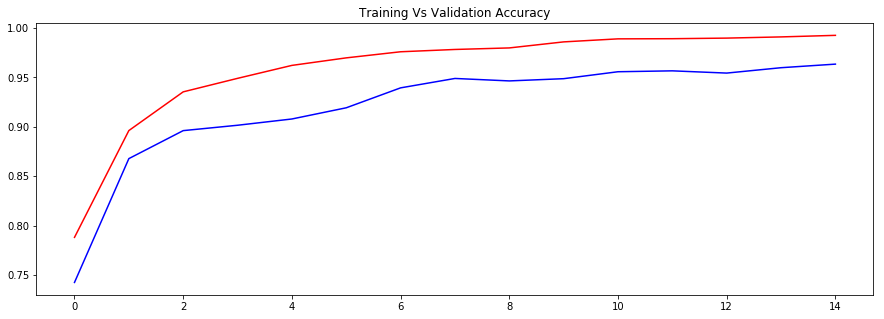

In [42]:
training_accuracy_list = []
validation_accuracy_list = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_gray_normalized, y_train = shuffle(X_train_gray_normalized, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_gray_normalized[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
        
        #Training Accuracy
        training_accuracy = evaluate(X_train_gray_normalized,y_train)
        training_accuracy_list.append(training_accuracy)
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        
        #Valdiation Accuracy
        validation_accuracy = evaluate(X_valid_gray_normalized, y_valid)
        validation_accuracy_list.append(validation_accuracy)
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
    
    #------------------Plot Training Vs Validation Accuracy------------------
    plt.figure(figsize = (15,5))
    plt.title('Training Vs Validation Accuracy')
    plt.plot(range(EPOCHS),training_accuracy_list,'r')
    plt.plot(range(EPOCHS),validation_accuracy_list,'b')
    saver.save(sess, './lenet')
    print("Model saved")

## Step 3: Model Analysis

### Training Performance

Start
Done


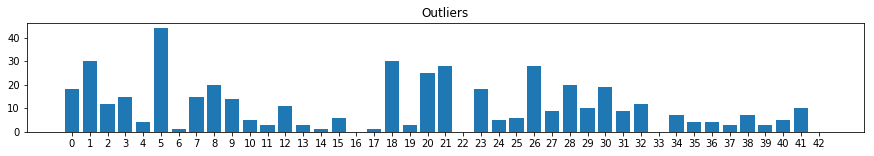

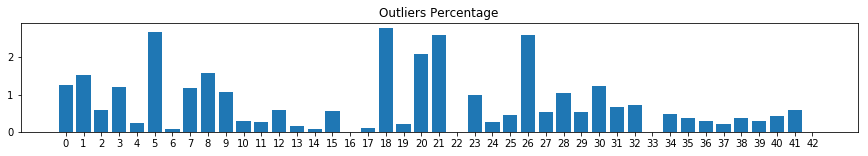

In [43]:
print('Start')

soft_max = tf.nn.softmax(logits=logits)

outliers_sum = [0] * n_classes
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    for i in range(len(X_train_gray_normalized)):
        img = X_train_gray_normalized[i].reshape(1,32,32,1)
        y_img = y_train[i]
        result = sess.run(soft_max, feed_dict={x: img, y: y_img, keep_prob : 1.0})
        L = np.argsort(-result,axis=1)
        if(L[:,0] != y_img):
            outliers_sum[y_img] += 1
            
plt.figure(figsize=(15,2))
plt.title('Outliers')
plt.xticks(range(n_classes))
plt.bar(range(n_classes),outliers_sum)

outliers_percent = [ x/y * 100 for x, y in zip(outliers_sum, train_len)]
plt.figure(figsize=(15,2))
plt.title('Outliers Percentage')
plt.xticks(range(n_classes))
plt.bar(range(n_classes),outliers_percent)

samples_List = []
for i in range(n_classes):
    for j in range(len(X_train_gray_normalized)):
        if(y_train[j] == i):
            samples_List.append(deNormalize_grayscale(X_train_gray_normalized[j]).reshape(32,32))
            break

plt.figure(figsize=(15,15))
count = 1
for i in range(len(outliers_percent)):
    if(outliers_percent[i] > 7):
        plt.subplot(6,8,count)
        plt.title('Image ' + str(i))
        plt.imshow(samples_List[i],cmap='gray')
        count += 1
print('Done')

### Visualize FeatureMaps

Start
Done


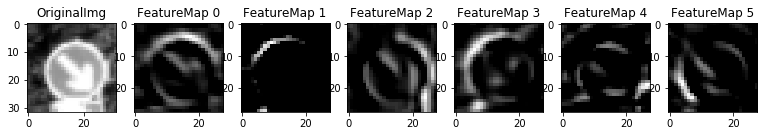

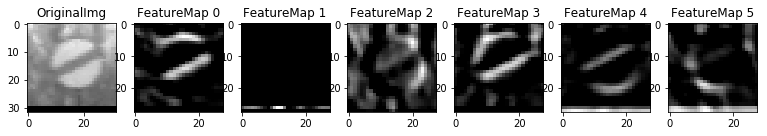

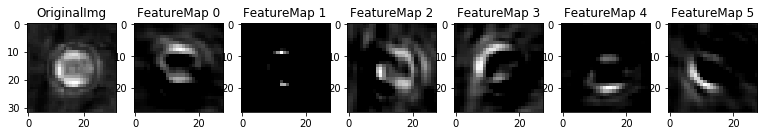

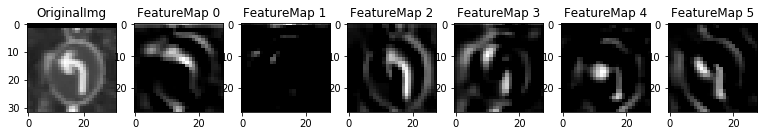

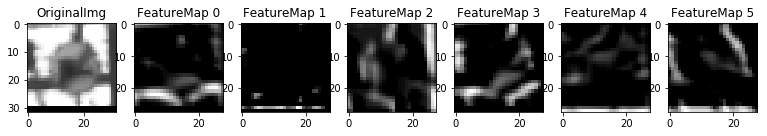

In [44]:
def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    
    plt.figure(plt_num, figsize=(15,15))
    plt.subplot(6,8,1)
    plt.title('OriginalImg')
    plt.imshow(image_input[0,:,:,0],cmap = 'gray')
    
    image_input = normalize_grayscale(image_input.reshape(32,32,1)).reshape(1,32,32,1)
    
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input, keep_prob: 1.0})
    featuremaps = activation.shape[3]
    
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+2) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number

        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

print("Start")
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    numSamples = 5
    for i in range(numSamples):
        index = random.randint(0, len(X_train_gray))
        image = X_train_gray[index]
        image = image.reshape(1,32,32,1)
        outputFeatureMap(image,conv1,-1,-1,i)
print("Done")


### Visualize First Layer's Weights

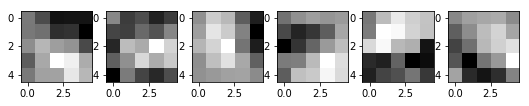

In [45]:
import numpy as np
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    w = weights['wc1'].eval()
    
    x_min = np.min(w)
    x_max = np.max(w)
    weights_normalized = (w - x_min) / (x_max - x_min)
    
    plt.figure(figsize=(12,12))   
    for featureMap in range(w.shape[3]):    
        plt.subplot(6,8,1)
        plt.subplot(6,8, featureMap+1) # sets the number of feature maps to show on each row and column
        plt.imshow(weights_normalized[:,:,0, featureMap], interpolation="nearest",cmap="gray")
    

### Visualize First Layer's Activations

Start
Done


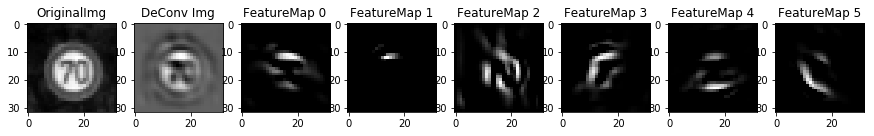

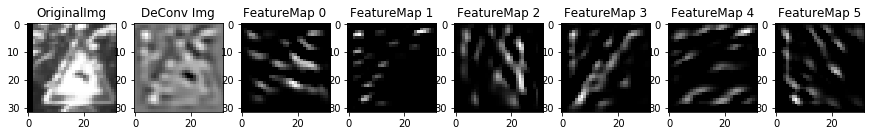

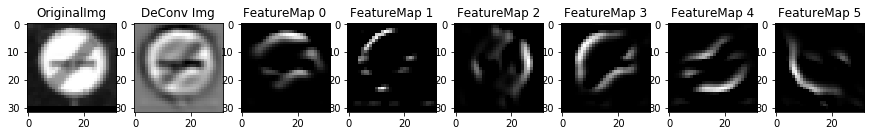

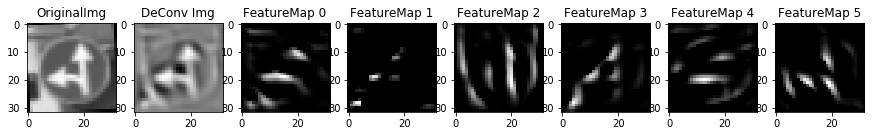

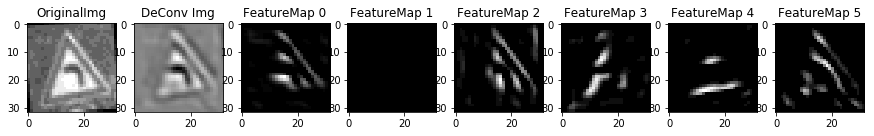

In [46]:
print("Start")
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    numSamples = 5
    for i in range(numSamples):
        #-----------------Get Random Input Image and Display it----------
        index = random.randint(0, len(X_train_gray))
        image_input = X_train_gray[index]
        image_input = image_input.reshape(1,32,32,1)
        
        plt.figure(i,figsize=(15,15))
        plt.subplot(6,8,1)
        plt.title('OriginalImg')
        plt.imshow(image_input[0,:,:,0],cmap = 'gray')
        #------------------Prepare Image--------------------------
        image_input_norm = normalize_grayscale(X_train_gray[index])
        image_input_norm = image_input.reshape(1,32,32,1)
        #---------------Apply DeConvoloution----------------------
        activations = conv1.eval(session=sess,feed_dict={x : image_input_norm, keep_prob:1.0})
        DeConv1 = sess.run(tf.cast(tf.nn.conv2d_transpose(activations,weights['wc1'],[1,32,32,1],[1,1,1,1], padding='VALID', name=None),tf.int64))
        DeConv1_deNorm = deNormalize_grayscale(DeConv1)
        plt.subplot(6,8,2)
        plt.title('DeConv Img')
        plt.imshow(DeConv1_deNorm[0,:,:,0], interpolation="nearest",cmap="gray")
        #--------------Feature Maps DeConvloution--------------
        featureMaps = weights['wc1'].eval().shape[3]
        for featuremap in range(featureMaps):
            weights_conv = weights['wc1'].eval()
            zero_weights = np.zeros(weights_conv.shape)
            zero_weights[:,:,0,featuremap] += weights_conv[:,:,0,featuremap]
            current_weights = tf.convert_to_tensor(zero_weights,tf.float32)

            DeConv1 = sess.run(tf.nn.conv2d_transpose(activations,current_weights,[1,32,32,1],[1,1,1,1], padding='VALID', name=None))
            DeConv1_Rectified = sess.run(tf.cast(tf.nn.relu(DeConv1),tf.int64))
            DeConv1_deNorm = deNormalize_grayscale(DeConv1_Rectified)
            plt.subplot(6,8,3+featuremap)
            plt.title('FeatureMap ' + str(featuremap))
            plt.imshow(DeConv1_deNorm[0,:,:,0], interpolation="nearest",cmap="gray")
            
            

print("Done")


## Step 4: Test Model on New Images

### Full TestData Evaluation

In [47]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test_gray_normalized, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.932


### Full TestData Analysis 

#### 2nd Best Accuracy Results

Start
Done


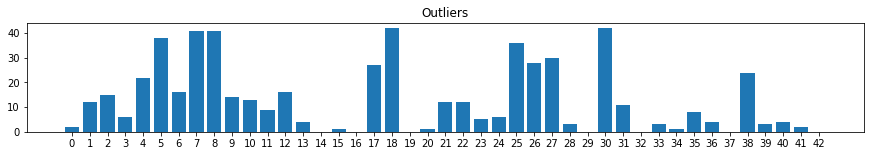

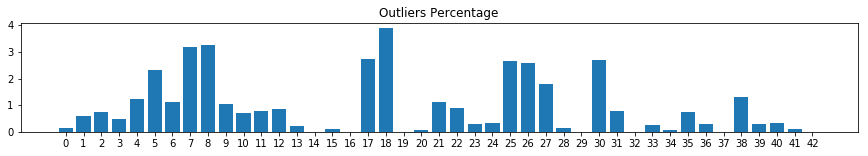

In [48]:
print('Start')

soft_max = tf.nn.softmax(logits=logits)

outliers_sum = [0] * n_classes
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    for i in range(len(X_test_gray_normalized)):
        img = X_test_gray_normalized[i].reshape(1,32,32,1)
        y_img = y_test[i]
        result = sess.run(soft_max, feed_dict={x: img, y: y_img, keep_prob : 1.0})
        L = np.argsort(-result,axis=1)
        if(L[:,0] == y_img or L[:,1] == y_img):
            pass
        else:
            outliers_sum[y_img] += 1

plt.figure(figsize=(15,2))
plt.title('Outliers')
plt.xticks(range(n_classes))
plt.bar(range(n_classes),outliers_sum)

outliers_percent = [ x/y * 100 for x, y in zip(outliers_sum, train_len)]
plt.figure(figsize=(15,2))
plt.title('Outliers Percentage')
plt.xticks(range(n_classes))
plt.bar(range(n_classes),outliers_percent)


plt.figure(figsize=(15,15))
count = 1
for i in range(len(outliers_percent)):
    if(outliers_percent[i] > 10):
        plt.subplot(6,8,count)
        plt.title('Image ' + str(i))
        plt.imshow(samples_List[i],cmap='gray')
        count += 1
print('Done')

### Sample Test Data Evaluation

#### Read csv and map labels to their original description

In [49]:
import csv
with open('signnames.csv', 'r') as f:
    reader = csv.reader(f)
    label_names = list(reader)
label_names = label_names[1:]

#### Randomly choose images from test data and display their results

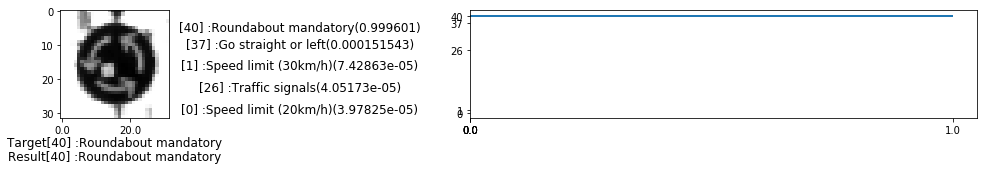

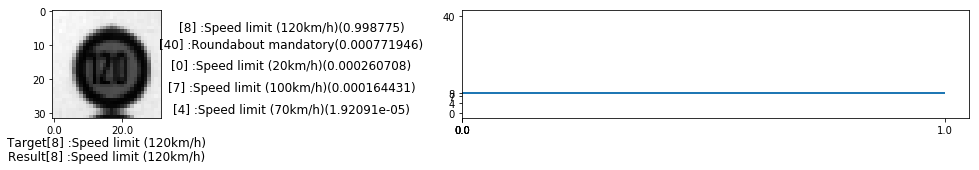

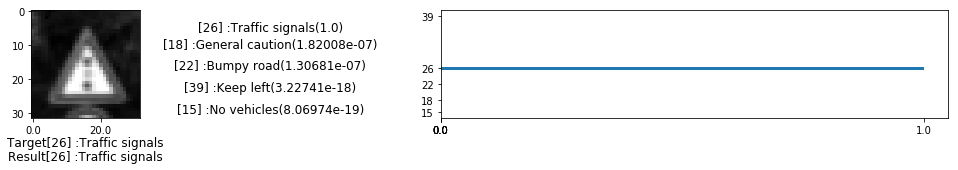

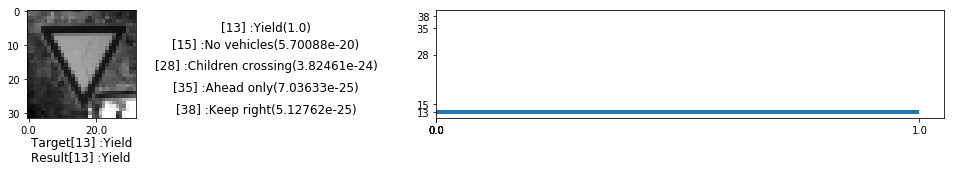

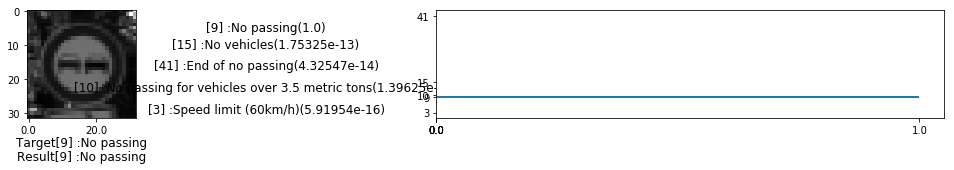

In [64]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

soft_max = tf.nn.softmax(logits=logits)
max_ids =  tf.nn.top_k(soft_max, k=5)

num = 5

for i in range(num):
    index = random.randint(0, len(X_test_gray))
    image = X_test_gray[index]
    image_normalized = normalize_grayscale(X_test_gray[index])
    
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('.'))
        ids = sess.run(max_ids, feed_dict={x: image_normalized.reshape(1,32,32,1), y: y_test[index], keep_prob : 1.0})
    
    plt.figure(i,figsize=(20,2))
    ax = plt.subplot(121)
    ax.text(0.5,-0.25, "Target" + "[" + str(y_test[index]) + "] :" + str(label_names[y_test[index]][1]), size=12, ha="center", transform=ax.transAxes)
    ax.text(0.5,-0.38, "Result" + "[" + str(ids.indices[0][0]) + "] :" + str(label_names[ids.indices[0][0]][1]), size=12, ha="center", transform=ax.transAxes)
    
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
    ax.text(2.2,0.8, "[" + str(ids.indices[0][0]) + "] :" + str(label_names[ids.indices[0][0]][1]) + "(" + str(ids.values[0][0]) + ")", size=12, ha="center", transform=ax.transAxes)
    ax.text(2.2,0.65, "[" + str(ids.indices[0][1]) + "] :" + str(label_names[ids.indices[0][1]][1]) + "(" + str(ids.values[0][1]) + ")", size=12, ha="center", transform=ax.transAxes)
    ax.text(2.2,0.45, "[" + str(ids.indices[0][2]) + "] :" + str(label_names[ids.indices[0][2]][1]) + "(" + str(ids.values[0][2]) + ")", size=12, ha="center", transform=ax.transAxes)
    ax.text(2.2,0.25, "[" + str(ids.indices[0][3]) + "] :" + str(label_names[ids.indices[0][3]][1]) + "(" + str(ids.values[0][3]) + ")", size=12, ha="center", transform=ax.transAxes)
    ax.text(2.2,0.05, "[" + str(ids.indices[0][4]) + "] :" + str(label_names[ids.indices[0][4]][1]) + "(" + str(ids.values[0][4]) + ")", size=12, ha="center", transform=ax.transAxes)
    ax.imshow(image.squeeze(),cmap = 'gray')
    
    ax = plt.subplot(122)
    plt.yticks(ids.indices[0])
    plt.xticks(ids.values[0])
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.barh(ids.indices[0],ids.values[0],align = 'center')